In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the datasets
print("Loading datasets...")
true_df = pd.read_csv('News_Dataset/True.csv')
fake_df = pd.read_csv('News_Dataset/Fake.csv')

# Display basic information about the datasets
print(f"True news dataset shape: {true_df.shape}")
print(f"Fake news dataset shape: {fake_df.shape}")

# Display the first few rows of each dataset to understand their structure
print("\
Sample of True news dataset:")
print(true_df.head(2))

print("\
Sample of Fake news dataset:")
print(fake_df.head(2))

# Check for missing values
print("\
Missing values in True news dataset:")
print(true_df.isnull().sum())

print("\
Missing values in Fake news dataset:")
print(fake_df.isnull().sum())

Loading datasets...
True news dataset shape: (21417, 4)
Fake news dataset shape: (23481, 4)
Sample of True news dataset:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
Sample of Fake news dataset:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 3

In [2]:
# Add labels to the datasets
true_df['label'] = 1  # 1 for true news
fake_df['label'] = 0  # 0 for fake news

# Combine the datasets
df_combined = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle the data
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Combined dataset shape: {df_combined.shape}")

# Check the distribution of labels
print("\
Label distribution:")
print(df_combined['label'].value_counts())

# Basic text cleaning function
def clean_text(text):
    if pd.isna(text) or text == '':
        return "empty_text"
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply text cleaning to the 'text' column
df_combined['cleaned_text'] = df_combined['text'].apply(clean_text)

# Split the data into features and labels
X = df_combined['cleaned_text']
y = df_combined['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\
Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Display a sample of cleaned text
print("\
Sample of cleaned text:")
print(X_train.iloc[0][:300] + "...")

Combined dataset shape: (44898, 5)
Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64
Training set size: (35918,)
Testing set size: (8980,)
Sample of cleaned text:
so the conway marriage just took a turn and kellyanne, still doing the tv circuit to promote trump s latest lies, may not even know it yet.while kellyanne was busy going on cable to say trump s incoherent, dangerous tweets should be ignored and people should focus on his incoherent, dangerous action...


In [3]:
# Create a function to remove 'reuters' from text
def remove_reuters(text):
    # Remove 'reuters' (case insensitive)
    return re.sub(r'\breuters\b', '', text, flags=re.IGNORECASE)

# Apply the function to create modified versions of training and test data
X_train_modified = X_train.apply(remove_reuters)
X_test_modified = X_test.apply(remove_reuters)

# Check a sample to confirm 'reuters' was removed
sample_idx = None
for i, text in enumerate(X_train):
    if 'reuters' in text.lower():
        sample_idx = i
        break

if sample_idx is not None:
    print("Original text sample with 'reuters':")
    print(X_train.iloc[sample_idx][:300] + "...")
    print("\
Modified text sample with 'reuters' removed:")
    print(X_train_modified.iloc[sample_idx][:300] + "...")
else:
    print("No sample with 'reuters' found in the first few examples.")

# Count occurrences of 'reuters' in the training data
reuters_count = sum(1 for text in X_train if 'reuters' in text.lower())
print(f"\
Number of training examples containing 'reuters': {reuters_count} out of {len(X_train)} ({reuters_count/len(X_train)*100:.2f}%)")

# Create TF-IDF vectorizers for both original and modified data
# We'll use trigrams (1-3 word sequences) to capture more context
tfidf_vectorizer_original = TfidfVectorizer(
    max_features=7500,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=5
)

tfidf_vectorizer_modified = TfidfVectorizer(
    max_features=7500,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=5
)

# Vectorize the original data
X_train_tfidf_original = tfidf_vectorizer_original.fit_transform(X_train)
X_test_tfidf_original = tfidf_vectorizer_original.transform(X_test)

# Vectorize the modified data (with 'reuters' removed)
X_train_tfidf_modified = tfidf_vectorizer_modified.fit_transform(X_train_modified)
X_test_tfidf_modified = tfidf_vectorizer_modified.transform(X_test_modified)

print(f"\
Original data vectorization: {X_train_tfidf_original.shape[1]} features")
print(f"Modified data vectorization: {X_train_tfidf_modified.shape[1]} features")

Original text sample with 'reuters':
jerusalem (reuters) - israeli prime minister benjamin netanyahu congratulated u.s. president donald trump for his speech against iran on friday, seeing an opportunity to change the 2015 nuclear deal with tehran as well as iranian conduct in the region. he (trump) boldly confronted iran s terrorist r...
Modified text sample with 'reuters' removed:
jerusalem () - israeli prime minister benjamin netanyahu congratulated u.s. president donald trump for his speech against iran on friday, seeing an opportunity to change the 2015 nuclear deal with tehran as well as iranian conduct in the region. he (trump) boldly confronted iran s terrorist regime (...
Number of training examples containing 'reuters': 17312 out of 35918 (48.20%)
Original data vectorization: 7500 features
Modified data vectorization: 7500 features


In [4]:
# Define the regularization parameter values to test
C_values = [0.1, 0.5, 1.0, 2.0, 5.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform cross-validation and find the best C value
def find_best_C(X_train_tfidf, y_train, C_values, cv):
    best_C = None
    best_score = 0
    
    print("Cross-validating to find optimal regularization strength:")
    for C in C_values:
        lr = LogisticRegression(C=C, max_iter=1000, random_state=42)
        scores = cross_val_score(lr, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"C={C}: Mean accuracy={mean_score:.4f}, Std={std_score:.4f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_C = C
    
    print(f"\
Best regularization parameter C: {best_C}")
    print(f"Best cross-validation score: {best_score:.4f}")
    
    return best_C, best_score

# Find the best C for the original data
print("\
--- Original Data (with 'reuters') ---")
best_C_original, best_score_original = find_best_C(X_train_tfidf_original, y_train, C_values, cv)

# Find the best C for the modified data
print("\
--- Modified Data (without 'reuters') ---")
best_C_modified, best_score_modified = find_best_C(X_train_tfidf_modified, y_train, C_values, cv)

--- Original Data (with 'reuters') ---
Cross-validating to find optimal regularization strength:
C=0.1: Mean accuracy=0.9742, Std=0.0021
C=0.5: Mean accuracy=0.9842, Std=0.0018
C=1.0: Mean accuracy=0.9874, Std=0.0013
C=2.0: Mean accuracy=0.9898, Std=0.0010
C=5.0: Mean accuracy=0.9913, Std=0.0014
Best regularization parameter C: 5.0
Best cross-validation score: 0.9913
--- Modified Data (without 'reuters') ---
Cross-validating to find optimal regularization strength:
C=0.1: Mean accuracy=0.9662, Std=0.0016
C=0.5: Mean accuracy=0.9763, Std=0.0018
C=1.0: Mean accuracy=0.9808, Std=0.0017
C=2.0: Mean accuracy=0.9832, Std=0.0019
C=5.0: Mean accuracy=0.9859, Std=0.0015
Best regularization parameter C: 5.0
Best cross-validation score: 0.9859


--- Test Results for Original Model (with 'reuters') ---
Accuracy: 0.9919
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4669
           1       0.99      0.99      0.99      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

--- Test Results for Modified Model (without 'reuters') ---
Accuracy: 0.9870
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.98      0.99      0.99      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

--- Model Comparison ---
Original model accuracy: 0.9919
Modified model accuracy: 0.9870
Difference: -0.0049


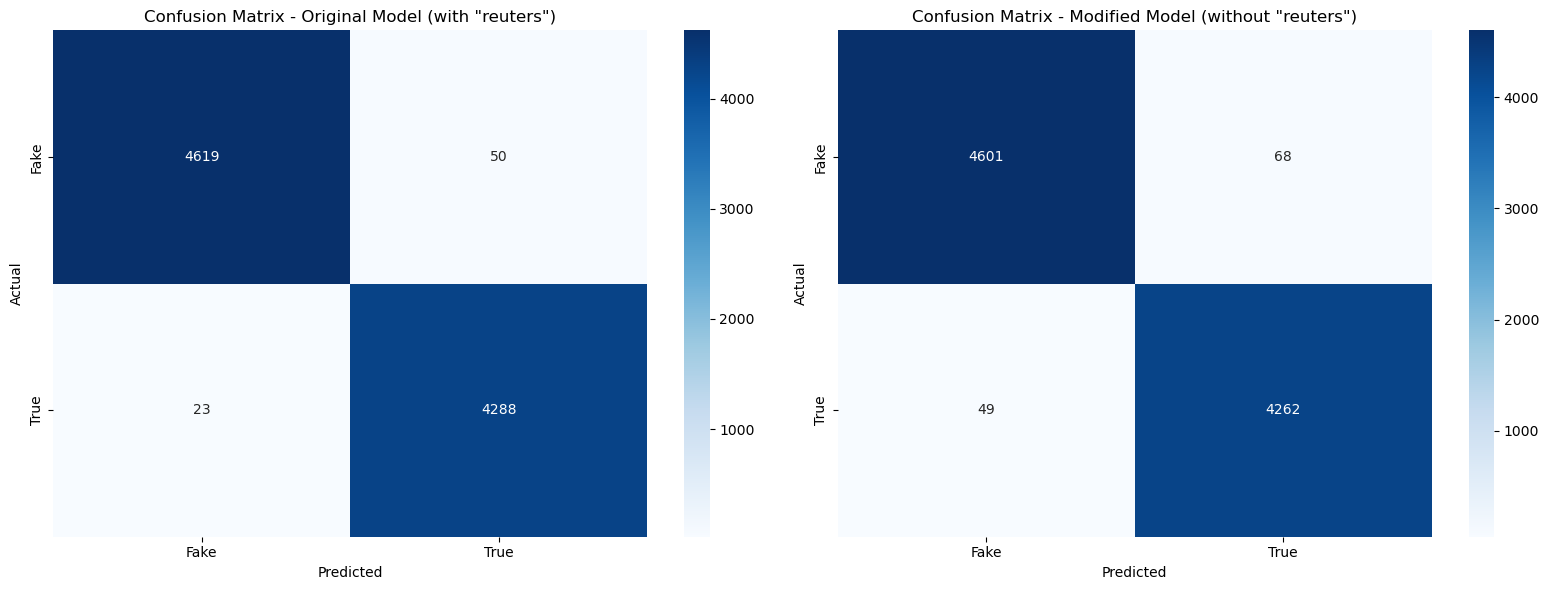

In [5]:
# Train the final models with the best regularization parameters
# Original data model
clf_original = LogisticRegression(C=best_C_original, max_iter=1000, random_state=42)
clf_original.fit(X_train_tfidf_original, y_train)

# Modified data model
clf_modified = LogisticRegression(C=best_C_modified, max_iter=1000, random_state=42)
clf_modified.fit(X_train_tfidf_modified, y_train)

# Evaluate both models on the test set
# Original model
y_pred_original = clf_original.predict(X_test_tfidf_original)
accuracy_original = accuracy_score(y_test, y_pred_original)
report_original = classification_report(y_test, y_pred_original)

# Modified model
y_pred_modified = clf_modified.predict(X_test_tfidf_modified)
accuracy_modified = accuracy_score(y_test, y_pred_modified)
report_modified = classification_report(y_test, y_pred_modified)

# Print results
print("\
--- Test Results for Original Model (with 'reuters') ---")
print(f"Accuracy: {accuracy_original:.4f}")
print("Classification Report:")
print(report_original)

print("\
--- Test Results for Modified Model (without 'reuters') ---")
print(f"Accuracy: {accuracy_modified:.4f}")
print("Classification Report:")
print(report_modified)

# Compare the models
print("\
--- Model Comparison ---")
print(f"Original model accuracy: {accuracy_original:.4f}")
print(f"Modified model accuracy: {accuracy_modified:.4f}")
print(f"Difference: {accuracy_modified - accuracy_original:.4f}")

# Create confusion matrices
cm_original = confusion_matrix(y_test, y_pred_original)
cm_modified = confusion_matrix(y_test, y_pred_modified)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original model confusion matrix
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'True'], 
            yticklabels=['Fake', 'True'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix - Original Model (with "reuters")')

# Modified model confusion matrix
sns.heatmap(cm_modified, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'True'], 
            yticklabels=['Fake', 'True'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix - Modified Model (without "reuters")')

plt.tight_layout()
plt.show()

In [6]:
 import joblib  
   
 # Save the modified TF-IDF vectorizer and logistic regression model to disk  
 joblib.dump(tfidf_vectorizer_modified, 'tfidf_vectorizer_modified.pkl')  
 joblib.dump(clf_modified, 'logistic_model_modified.pkl')  
   
 print("Model and vectorizer exported as 'tfidf_vectorizer_modified.pkl' and 'logistic_model_modified.pkl'")  


Model and vectorizer exported as 'tfidf_vectorizer_modified.pkl' and 'logistic_model_modified.pkl'


In [7]:
# Let's retrain our model with the updated preprocessing (which neutralizes quotes) and save the new model and vectorizer.

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib

# Define updated preprocessing

def preprocess_text(text):
    # Remove 'reuters' (if necessary)
    text = re.sub(r'\reuters\', '', text, flags=re.IGNORECASE)
    # Replace quoted text with a neutral token
    text = re.sub(r'(["\"]).*?\1', ' [QUOTE] ', text)
    return text.strip()

# Load your data; assuming you have two CSV files: 'Fake.csv' and 'True.csv'
# They might have a column like 'text' for the article content
fake_df = pd.read_csv('News_dataset/Fake.csv')
true_df = pd.read_csv('News_dataset/True.csv')

# We'll assume both CSVs have a 'text' column; add a label column (0 for fake, 1 for true)
fake_df['label'] = 0
true_df['label'] = 1

# Combine the dataframes
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess the text
df['clean_text'] = df['text'].apply(preprocess_text)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Create the TF-IDF vectorizer and fit on training data
vectorizer_quote = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_quote.fit_transform(X_train)

# Train a logistic regression model
clf_quote = LogisticRegression(max_iter=1000)
clf_quote.fit(X_train_tfidf, y_train)

# Save the new vectorizer and model
joblib.dump(vectorizer_quote, 'tfidf_vectorizer_quote.pkl')
joblib.dump(clf_quote, 'logistic_model_quote.pkl')

print("Training complete. New tfidf_vectorizer_quote.pkl and logistic_model_quote.pkl saved")

# Optional test prediction on a sample
sample_text = "Canada’s tariffs: Trump falsely claimed in a social media post Tuesday that Canada is \"ONE OF THE HIGHEST TARIFFING NATIONS ANYWHERE IN THE WORLD.\" In fact, Canada has long had relatively low tariffs."
clean_sample = preprocess_text(sample_text)
sample_vector = vectorizer_quote.transform([clean_sample])
prediction = clf_quote.predict(sample_vector)[0]
print("Sample prediction (0: Fake, 1: True):", prediction)

Training complete. New tfidf_vectorizer_quote.pkl and logistic_model_quote.pkl saved
Sample prediction (0: Fake, 1: True): 0


Random Article Index: 30129
Label (0: Fake, 1: True): 1
Original Article Text:
BAGHDAD (Reuters) - Iraqi Kurdish political parties opposed to regional leader Masoud Barzani reported attacks on their offices in several cities overnight, hours after Barzani announced his resignation, brought low by a failed push for independence. The Patriotic Union of Kurdistan (PUK), the Movement for Change and Gorran said in separate statements several of their offices in the Duhok region, north of the Kurdish capital Erbil, were looted or burnt overnight. No casualties were reported. The semi-autonomous Kurdistan Regional Government (KRG) in northern Iraq said it had ordered the local police forces, known as Asayish, to stop the attacks.  Barzani, 71, said on Sunday he would give up his position as president on Nov. 1 after an independence referendum he championed in northern Iraq backfired and triggered military and economic retaliation by the Iraqi government. The veteran guerrilla leader has run I

<Figure size 2000x300 with 0 Axes>

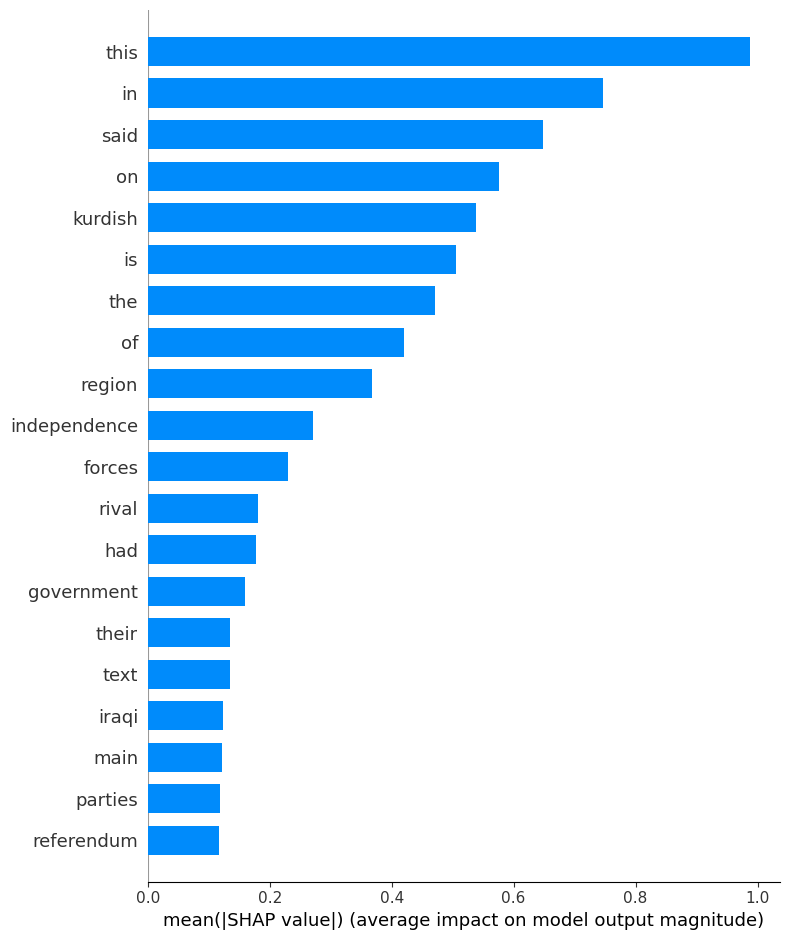

SHAP summary plot saved as 'random_article_shap_summary_plot.png'
done


In [8]:
# This cell will load the training data again, pick a random article, preprocess it and run SHAP analysis on it.

import pandas as pd
import numpy as np
import joblib
import re
import shap
import matplotlib.pyplot as plt

# Load data files
fake_df = pd.read_csv('News_Dataset/Fake.csv')
true_df = pd.read_csv('News_Dataset/True.csv')

# Add label columns
fake_df['label'] = 0
true_df['label'] = 1

# Combine the dataframes
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use the already defined preprocessing function

def preprocess_text(text):
    # Remove 'reuters' if needed
    text = re.sub(r'\breuters\b', '', text, flags=re.IGNORECASE)
    # Replace quoted text with a neutral token
    text = re.sub(r'(["\']).*?\1', ' [QUOTE] ', text)
    return text.strip()

# Pick a random article from the dataset
random_idx = np.random.randint(0, len(df))
random_article = df.iloc[random_idx]['text']
label = df.iloc[random_idx]['label']

print("Random Article Index:", random_idx)
print("Label (0: Fake, 1: True):", label)
print("Original Article Text:")
print(random_article)

# Preprocess the article for our model
clean_text = preprocess_text(random_article)

# Load the trained vectorizer and model
vectorizer_quote = joblib.load('tfidf_vectorizer_quote.pkl')
clf_quote = joblib.load('logistic_model_quote.pkl')

# Vectorize the article
article_vector = vectorizer_quote.transform([clean_text])

# Create a SHAP explainer using a small background sample
background = vectorizer_quote.transform(["This is a background text"])
explainer = shap.LinearExplainer(clf_quote, background)

# Calculate SHAP values for the random article
shap_values = explainer.shap_values(article_vector)

# Visualize a force plot for the sample article
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, shap_values[0], features=article_vector.toarray()[0], feature_names=vectorizer_quote.get_feature_names_out(), matplotlib=True, show=False)
plt.tight_layout()
plt.savefig('random_article_shap_force_plot.png')
plt.close()

print("\
SHAP force plot saved as 'random_article_shap_force_plot.png'")

# Display the top features
feature_names = vectorizer_quote.get_feature_names_out()
article_array = article_vector.toarray()[0]
present_features = [(feature_names[i], article_array[i], shap_values[0][i]) for i in range(len(feature_names)) if article_array[i] > 0]
present_features.sort(key=lambda x: abs(x[2]), reverse=True)
print("\
Top features for this random article:")
for feature, tfidf_value, shap_val in present_features[:15]:
    print('- ' + feature + ": TF-IDF = " + str(round(tfidf_value, 4)) + ", SHAP value = " + str(round(shap_val, 4)))

# Global SHAP summary plot for this single article
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, article_vector.toarray(), feature_names=feature_names, plot_type='bar')
plt.tight_layout()
plt.savefig('random_article_shap_summary_plot.png')
plt.close()

print("\
SHAP summary plot saved as 'random_article_shap_summary_plot.png'")

print("done")